In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns

print('Tensorflow Version {}'.format(tf.__version__))

pd.reset_option('display.max_rows')



Tensorflow Version 2.4.1


### 1.1 Data Preprocessing

In [2]:
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

In [3]:
train_dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = train_dataset['label']
X_train = train_dataset.drop(['label'],axis=1)

In [5]:
y_train.shape

(42000,)

In [6]:
X_train.shape

(42000, 784)

### 1.2 Missing Values

In [7]:
df_miss = pd.DataFrame(train_dataset.isnull().sum(),columns=['NMiss'])
df_miss[df_miss['NMiss']>0]

,NMiss


In [8]:
df_miss = pd.DataFrame(test_dataset.isnull().sum(),columns=['NMiss'])
df_miss[df_miss['NMiss']>0]

,NMiss


### 1.3 Normalizationand reshaping

In [9]:
X_train = X_train/255.0
test_dataset = test_dataset/255.0

In [10]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test_dataset = test_dataset.values.reshape(-1,28,28,1)

In [11]:
X_train[0].shape

(28, 28, 1)

### 1.4 On-Hot-Encoding

In [12]:
import tensorflow 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)

print('Shape of y_train after one hot encoding {}'.format(y_train.shape))

Shape of y_train after one hot encoding (42000, 10)


In [13]:
y_train[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

### 2. Train and Test Split

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True, test_size=0.2)

print('Size of train dataset is {}'.format(x_train.shape))
print('Size of the val dataset is {}'.format(x_val.shape))

Size of train dataset is (33600, 28, 28, 1)
Size of the val dataset is (8400, 28, 28, 1)


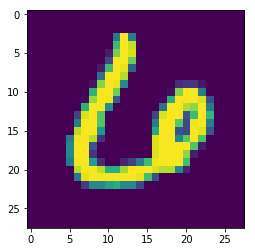

In [15]:
#visulaization of training set
import random
i = random.randint(10,5000)
plt.imshow(x_train[i][:,:,0])

### 3. CNN Model

In [16]:
# setting up model parameters
input_shape = (28,28,1)
batch_size = 64
num_classes = y_train.shape[1]
epochs = 20

In [17]:
num_classes

10

In [18]:
# CNN model

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding ='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding ='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_classes, activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# creating a callback for 99.55% accuracy

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') is not None and logs.get('acc')> 0.995):
            print("\n Reached 99.5% of accuracy!!")
            self.model.stop_training=True
            
callback= myCallback()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

datagen.fit(x_train)

In [21]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                  epochs=epochs,
                  validation_data= (x_val, y_val),
                  callbacks = [callback]
                   ) 

Epoch 1/20
525/525 [==============================] - 74s 138ms/step - loss: 0.7726 - accuracy: 0.7411 - val_loss: 0.0643 - val_accuracy: 0.9805
Epoch 2/20
525/525 [==============================] - 72s 137ms/step - loss: 0.1379 - accuracy: 0.9588 - val_loss: 0.0420 - val_accuracy: 0.9862
Epoch 3/20
525/525 [==============================] - 74s 141ms/step - loss: 0.0918 - accuracy: 0.9730 - val_loss: 0.0386 - val_accuracy: 0.9877
Epoch 4/20
525/525 [==============================] - 75s 143ms/step - loss: 0.0764 - accuracy: 0.9766 - val_loss: 0.0361 - val_accuracy: 0.9880
Epoch 5/20
525/525 [==============================] - 74s 141ms/step - loss: 0.0687 - accuracy: 0.9796 - val_loss: 0.0224 - val_accuracy: 0.9920
Epoch 6/20
525/525 [==============================] - 71s 135ms/step - loss: 0.0636 - accuracy: 0.9811 - val_loss: 0.0301 - val_accuracy: 0.9890
Epoch 7/20
525/525 [==============================] - 74s 140ms/step - loss: 0.0575 - accuracy: 0.9838 - val_loss: 0.0289 - val_ac

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy curve for Training and Validation Dataset')

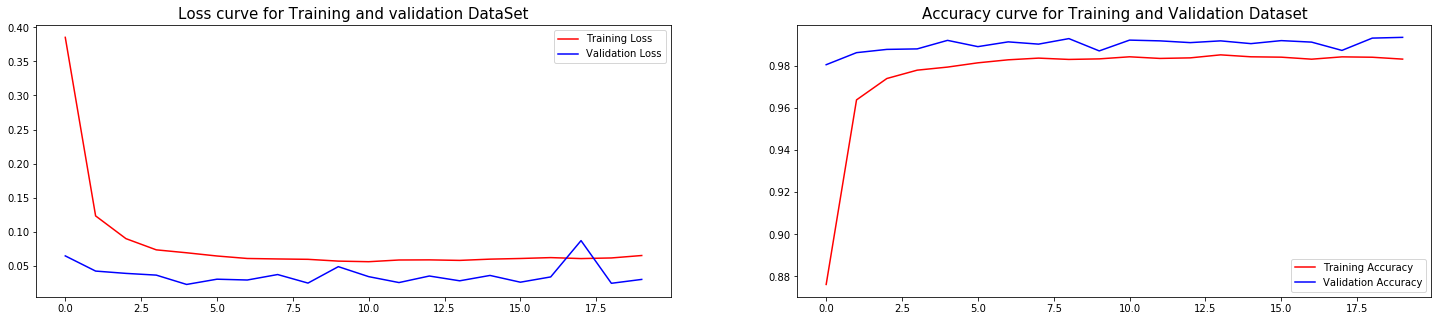

In [23]:
fig, ax = plt.subplots(1,2,figsize=(25,5))

#Loss Curve
ax[0].plot(history.history['loss'], color='r', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='b', label='Validation Loss')
ax[0].legend(loc='best')
ax[0].set_title('Loss curve for Training and validation DataSet', color='k', size=15)

#Accuracy Curve
ax[1].plot(history.history['accuracy'], color='r', label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
ax[1].legend(loc='best')
ax[1].set_title('Accuracy curve for Training and Validation Dataset', size=15)

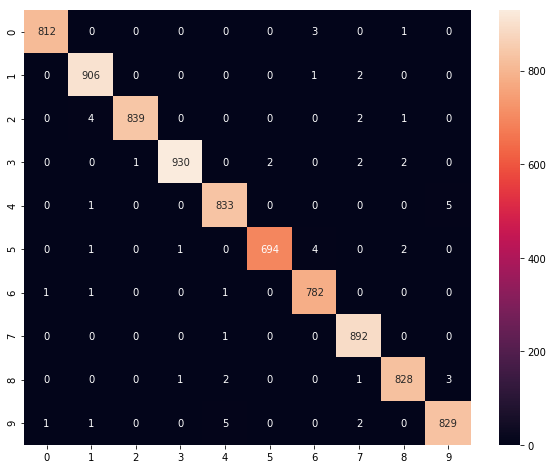

In [24]:
y_val_predict = model.predict(x_val)

y_val_predict_class = np.argmax(y_val_predict, axis=1)


y_val_true_class = np.argmax(y_val, axis=1)


confusion_matrix = tf.math.confusion_matrix(y_val_true_class, y_val_predict_class)


# heatmap for confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix, annot=True, fmt='g')

In [25]:
# predict result of test dataset

predict_test = model.predict(test_dataset)
results = np.argmax(predict_test, axis=1)


print(results)

[2 0 9 ... 3 9 2]


In [26]:
# converting to csv for submission
results = pd.Series(results, name='Label')

final_result = pd.concat([pd.Series(range(1, test_dataset.shape[0]+1), name='ImageId'), results], axis=1)


final_result.to_csv('CNN_digit_classification_TensorFlow.csv', index=False)